**CONFIGURATION**

In [9]:
!pip install dask polars memory-profiler

In [10]:
import pandas as pd
import dask.dataframe as dd
import polars as pl
import time
import psutil
import os
import matplotlib.pyplot as plt

In [7]:
# Step 1: Install necessary packages and authenticate Kaggle API
from google.colab import files
files.upload()  # Upload kaggle.json (your Kaggle API key)

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luqunited","key":"0d88fb511e0d66f36313f721a4975163"}'}

**TASK 1 - DOWNLOAD THE DATASET**

In [8]:
import os

# Setup for Kaggle API
os.makedirs("/root/.kaggle", exist_ok=True)
os.system("cp kaggle.json /root/.kaggle/")
os.system("chmod 600 /root/.kaggle/kaggle.json")

# Download dataset
!kaggle datasets download -d elemento/nyc-yellow-taxi-trip-data
!unzip -q nyc-yellow-taxi-trip-data.zip

Dataset URL: https://www.kaggle.com/datasets/elemento/nyc-yellow-taxi-trip-data
License(s): U.S. Government Works
 99% 1.76G/1.78G [00:12<00:00, 270MB/s]
100% 1.78G/1.78G [00:12<00:00, 157MB/s]


**COMBINE THE DATASET**

In [9]:
import dask.dataframe as dd

# List all exact file names
file_list = [
    "yellow_tripdata_2015-01.csv",
    "yellow_tripdata_2016-01.csv",
    "yellow_tripdata_2016-02.csv",
    "yellow_tripdata_2016-03.csv"
]

# Read all into Dask DataFrame
ddf_combined = dd.read_csv(file_list)

# (Optional) Save combined output as single CSV
ddf_combined.to_csv("combined_yellow_tripdata.csv", single_file=True, index=False)

# Preview
ddf_combined.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2015-01-15 19:05:39,2015-01-15 19:23:42,1,1.59,-73.993896,40.750111,1,N,-73.974785,40.750618,1,12.0,1.0,0.5,3.25,0.0,0.3,17.05
1,1,2015-01-10 20:33:38,2015-01-10 20:53:28,1,3.30,-74.001648,40.724243,1,N,-73.994415,40.759109,1,14.5,0.5,0.5,2.00,0.0,0.3,17.80
2,1,2015-01-10 20:33:38,2015-01-10 20:43:41,1,1.80,-73.963341,40.802788,1,N,-73.951820,40.824413,2,9.5,0.5,0.5,0.00,0.0,0.3,10.80
3,1,2015-01-10 20:33:39,2015-01-10 20:35:31,1,0.50,-74.009087,40.713818,1,N,-74.004326,40.719986,2,3.5,0.5,0.5,0.00,0.0,0.3,4.80
4,1,2015-01-10 20:33:39,2015-01-10 20:52:58,1,3.00,-73.971176,40.762428,1,N,-74.004181,40.742653,2,15.0,0.5,0.5,0.00,0.0,0.3,16.30


**TASK 2 - LOAD AND INSPECT DATA**

In [4]:
import pandas as pd

df = pd.read_csv("combined_yellow_tripdata.csv", nrows=500000)  # Initial sample
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Data Types:\n", df.dtypes)

Shape: (500000, 19)
Columns: ['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'pickup_longitude', 'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag', 'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount']
Data Types:
 VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            int64
trip_distance            float64
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             flo

**TASK 3.1 - LOAD LESS DATA**

In [11]:
use_cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'trip_distance', 'fare_amount']
filtered_df = pd.read_csv("combined_yellow_tripdata.csv", usecols=use_cols, nrows=100000)
print(filtered_df.head())

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:39   2015-01-15 19:23:42                1           1.59   
1  2015-01-10 20:33:38   2015-01-10 20:53:28                1           3.30   
2  2015-01-10 20:33:38   2015-01-10 20:43:41                1           1.80   
3  2015-01-10 20:33:39   2015-01-10 20:35:31                1           0.50   
4  2015-01-10 20:33:39   2015-01-10 20:52:58                1           3.00   

   fare_amount  
0         12.0  
1         14.5  
2          9.5  
3          3.5  
4         15.0  


**TASK 3.2 - CHUNKING**

In [12]:
chunks = pd.read_csv("combined_yellow_tripdata.csv", chunksize=100000, usecols=use_cols)
chunk_list = [chunk for chunk in chunks]
print(chunk_list[0].head())

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance
0  2015-01-15 19:05:39   2015-01-15 19:23:42                1           1.59
1  2015-01-10 20:33:38   2015-01-10 20:53:28                1           3.30
2  2015-01-10 20:33:38   2015-01-10 20:43:41                1           1.80
3  2015-01-10 20:33:39   2015-01-10 20:35:31                1           0.50
4  2015-01-10 20:33:39   2015-01-10 20:52:58                1           3.00


**TASK 3.3 - OPTIMIZE DATA TYPES**

In [12]:
df_opt = df.copy()
df_opt['passenger_count'] = df_opt['passenger_count'].astype('uint8')
df_opt['trip_distance'] = df_opt['trip_distance'].astype('float32')
df_opt['fare_amount'] = df_opt['fare_amount'].astype('float32')
print(df_opt.dtypes)

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count            uint8
trip_distance            float32
pickup_longitude         float64
pickup_latitude          float64
RateCodeID                 int64
store_and_fwd_flag        object
dropoff_longitude        float64
dropoff_latitude         float64
payment_type               int64
fare_amount              float32
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
dtype: object


**TASK 3.4 - SAMPLING**

In [7]:
sample_df = df.sample(frac=0.1, random_state=1)
print(sample_df.shape)

(50000, 19)


**TASK 3.5 - PARALLEL PROCESSING WITH DASK**

In [13]:
import dask.dataframe as dd
dask_df = dd.read_csv("combined_yellow_tripdata.csv", usecols=use_cols, blocksize="25MB")
print(dask_df.head())

  tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-01-15 19:05:39   2015-01-15 19:23:42                1           1.59   
1  2015-01-10 20:33:38   2015-01-10 20:53:28                1           3.30   
2  2015-01-10 20:33:38   2015-01-10 20:43:41                1           1.80   
3  2015-01-10 20:33:39   2015-01-10 20:35:31                1           0.50   
4  2015-01-10 20:33:39   2015-01-10 20:52:58                1           3.00   

   fare_amount  
0         12.0  
1         14.5  
2          9.5  
3          3.5  
4         15.0  


**TASK 4 - COMPARATIVE ANALYSIS**

In [19]:
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns

def measure_perf(label, func):
    process = psutil.Process()
    start_mem = process.memory_info().rss / 1e6
    start_time = time.time()
    result = func()
    end_time = time.time()
    end_mem = process.memory_info().rss / 1e6
    return {
        'Method': label,
        'Time (s)': round(end_time - start_time, 2),
        'Memory (MB)': round(end_mem - start_mem, 2)
    }

results = []

results.append(measure_perf("Pandas", lambda: pd.read_csv("combined_yellow_tripdata.csv", usecols=use_cols)))
results.append(measure_perf("Polars", lambda: pl.read_csv("combined_yellow_tripdata.csv", columns=use_cols)))
results.append(measure_perf("Dask", lambda: dd.read_csv("combined_yellow_tripdata.csv", usecols=use_cols, blocksize="25MB")))

perf_df = pd.DataFrame(results)

   Method  Time (s)  Memory (MB)
0  Pandas     99.27      3495.26
1  Polars     43.35      4401.98
2    Dask      1.88      -532.30


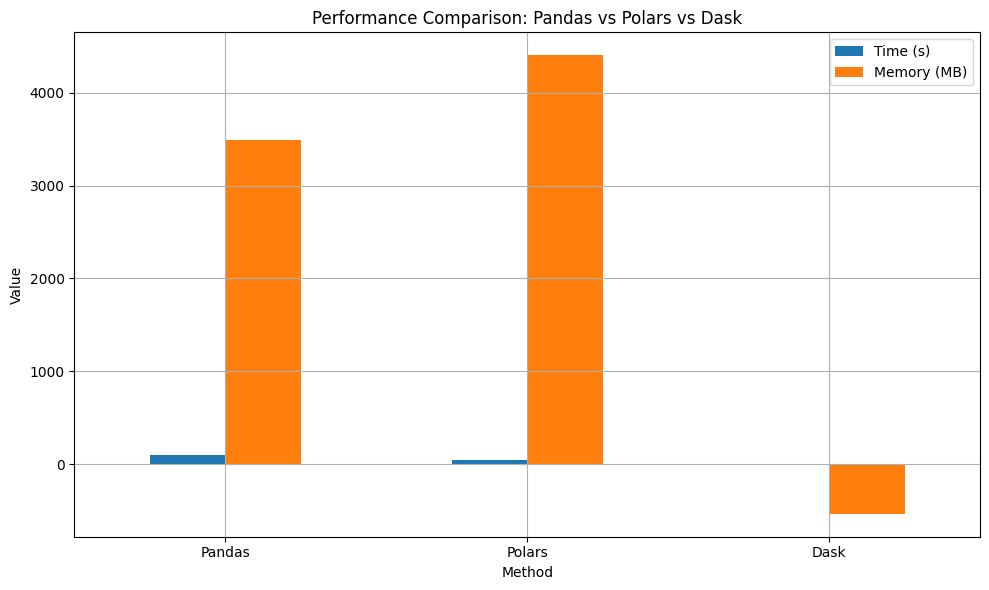

In [20]:
import matplotlib.pyplot as plt

# Display performance table
print(perf_df)

# Bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
perf_df.set_index("Method")[["Time (s)", "Memory (MB)"]].plot(kind='bar', ax=ax1)
plt.title("Performance Comparison: Pandas vs Polars vs Dask")
plt.ylabel("Value")
plt.xticks(rotation=0)
plt.grid(True)
plt.tight_layout()
plt.show()